# Классификация - и снова в бой!


Сегодня мы поговорим о том, чему же мы научились за последние практики?

Мы освоили основным методы работы как с данными, на основе которых можно решить задачу классификации, так и с моделями, которые это делают! Щикарррно!

Сегодняшняя задачка как всегда несложная, но очень важная - нам предстоит предсказывать болезни сердца!

В вашем распоряжении датасет [Heart Disease UCI](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci). Ваша задача предсказать, есть ли у человека заболевание сердца или нет.

Как всегда, ждем от вас полноценного анализа исходных данных, подготовка необходимой предобработки, feature engineering и поиск лучшего варианта, которный даст наибольшую метрику!

* Задача под звездочкой. Попробуйте реализовать такую систему, которая реже пропускает больных пациентов - мы ведь не хотим больным людям говорить, что они здоровы, хотя это не так?

Мы желаем вам удачи - постарайтесь применить все накопленные знания и, может, чуть больше! Успехов!

In [4]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
df = pd.read_csv("heart_cleveland_upload.csv")
df.rename(columns={"condition": "target"}, inplace=True)

categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df[categorical_features + ["target"]] = df[categorical_features + ["target"]].astype(
    "category"
)

display(df)
display(df.info())
display(df.isna().sum())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       297 non-null    int64   
 1   sex       297 non-null    category
 2   cp        297 non-null    category
 3   trestbps  297 non-null    int64   
 4   chol      297 non-null    int64   
 5   fbs       297 non-null    category
 6   restecg   297 non-null    category
 7   thalach   297 non-null    int64   
 8   exang     297 non-null    category
 9   oldpeak   297 non-null    float64 
 10  slope     297 non-null    category
 11  ca        297 non-null    category
 12  thal      297 non-null    category
 13  target    297 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 15.6 KB


None

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Main functions

In [6]:
ALL_RESULTS = pd.DataFrame(
    data={},
    columns=[
        "name",
        "train_auc",
        "train_accuracy",
        "train_recall",
        "train_precision",
        "train_f1",
        "test_auc",
        "test_accuracy",
        "test_recall",
        "test_precision",
        "test_f1",
    ],
)


def add_results_to_compare(name, results):
    global ALL_RESULTS
    name_dict = {"name": name}
    name_dict.update(results)
    cur_df = pd.DataFrame([name_dict])
    ALL_RESULTS = pd.concat([ALL_RESULTS, cur_df], axis=0)

In [7]:
def get_metrics(y_true, y_pred, prefix):
    return {
        f"{prefix}auc": metrics.roc_auc_score(y_true, y_pred),
        f"{prefix}accuracy": metrics.accuracy_score(y_true, y_pred),
        f"{prefix}recall": metrics.recall_score(y_true, y_pred),
        f"{prefix}precision": metrics.precision_score(y_true, y_pred),
        f"{prefix}f1": metrics.f1_score(y_true, y_pred),
    }


def get_train_test_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    train_metrics = get_metrics(y_train_true, y_train_pred, "train_")
    test_metrics = get_metrics(y_test_true, y_test_pred, "test_")
    train_metrics.update(test_metrics)
    return train_metrics

In [8]:
def model_pipeline(data, name):
    df_train, df_test = train_test_split(
        data, test_size=0.25, stratify=data["target"], random_state=RANDOM_SEED
    )

    y_train_true = df_train.pop("target")
    y_test_true = df_test.pop("target")

    logreg = LogisticRegression(random_state=RANDOM_SEED)

    scaler = StandardScaler().fit(df_train)
    df_train_scale = scaler.transform(df_train)
    df_test_scale = scaler.transform(df_test)

    logreg.fit(df_train_scale, y_train_true)

    y_train_pred = logreg.predict(df_train_scale)
    y_test_pred = logreg.predict(df_test_scale)

    results = get_train_test_metrics(
        y_train_true, y_train_pred, y_test_true, y_test_pred
    )
    add_results_to_compare(name, results)

In [9]:
def plot_continuous_feature(data, feature):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    sns.histplot(data[feature], kde=True, ax=axes[0])
    sns.boxplot(data[feature], orient="v", ax=axes[1])
    sns.boxplot(data=data, x="target", y=feature, ax=axes[2])
    plt.suptitle(feature)
    plt.show()


def plot_categorical_feature(data, feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    feature_df = (
        data.groupby([feature], observed=False).size().reset_index(name="counts")
    )
    sns.barplot(feature_df, x=feature, y="counts", ax=axes[0])
    feature_df = (
        data.groupby([feature, "target"], observed=False)
        .size()
        .reset_index(name="counts")
    )
    sns.barplot(feature_df, x=feature, y="counts", hue="target", ax=axes[1])
    plt.suptitle(feature)
    plt.show()

### EDA

Выводы по EDA в конце одним текстом

#### Целевая переменная

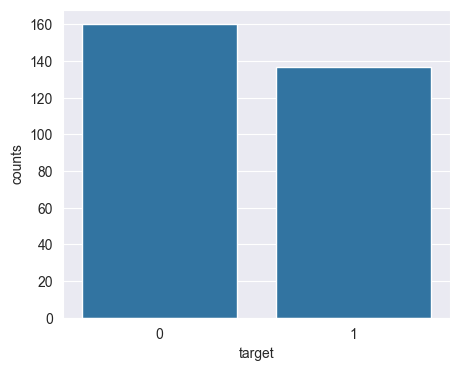

In [10]:
plt.figure(figsize=(5, 4))
target_tmp = df.groupby(["target"], observed=False).size().reset_index(name="counts")
sns.barplot(target_tmp, x="target", y="counts")
plt.show()

#### Непрерывные признаки

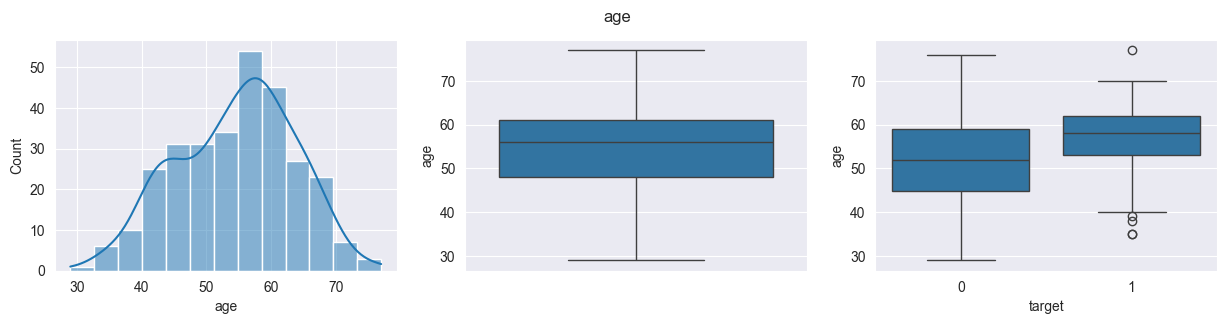

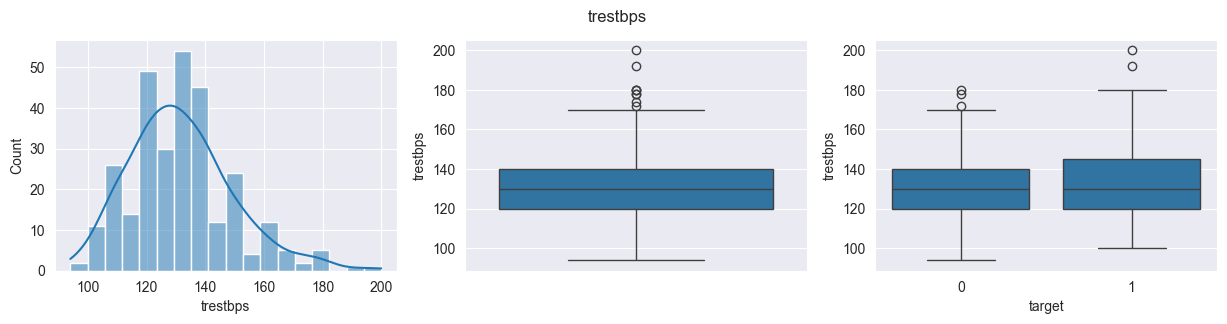

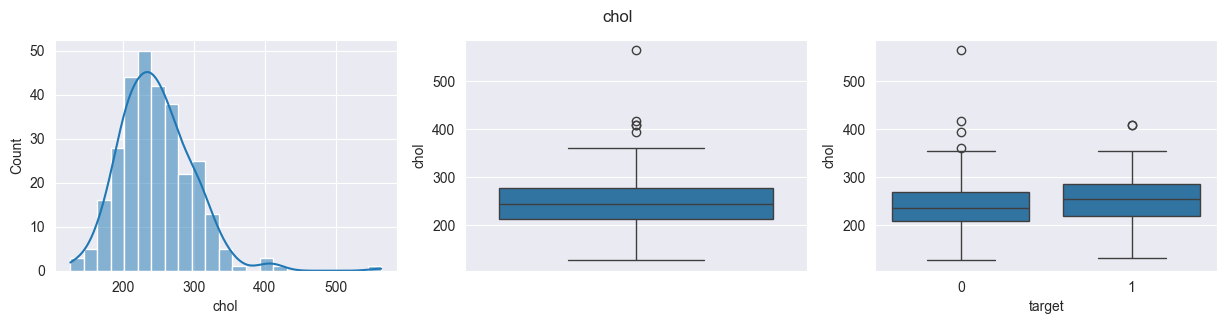

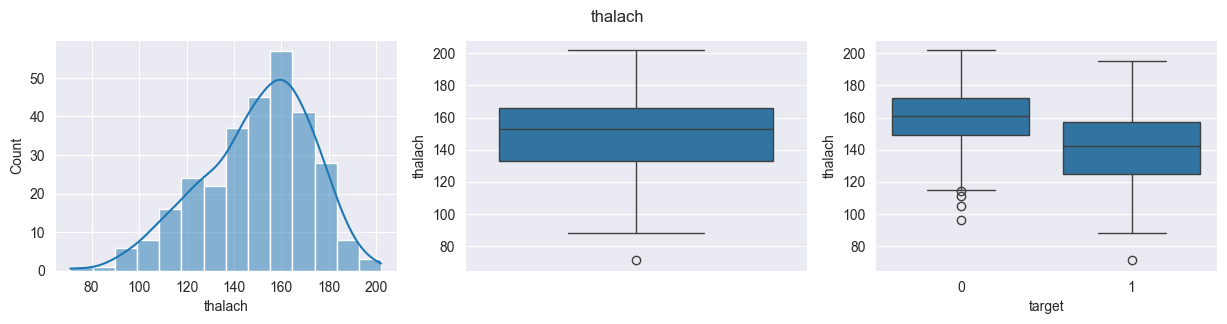

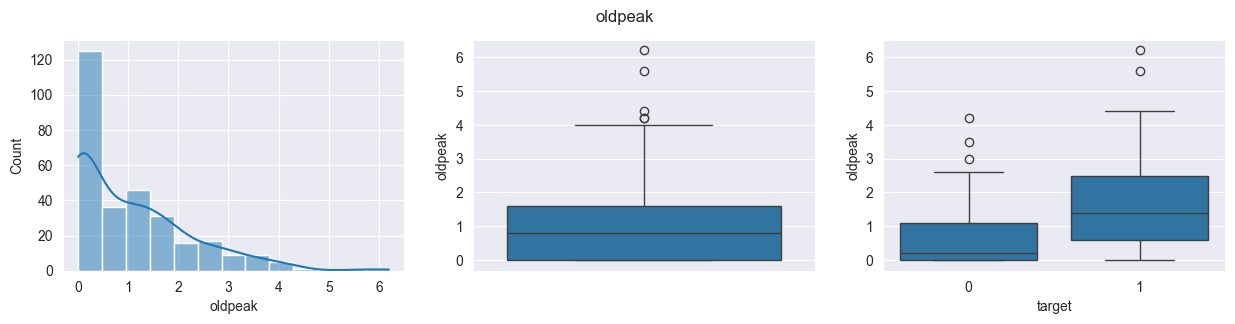

In [11]:
for feature in continuous_features:
    plot_continuous_feature(df, feature)

#### Категориальные признаки

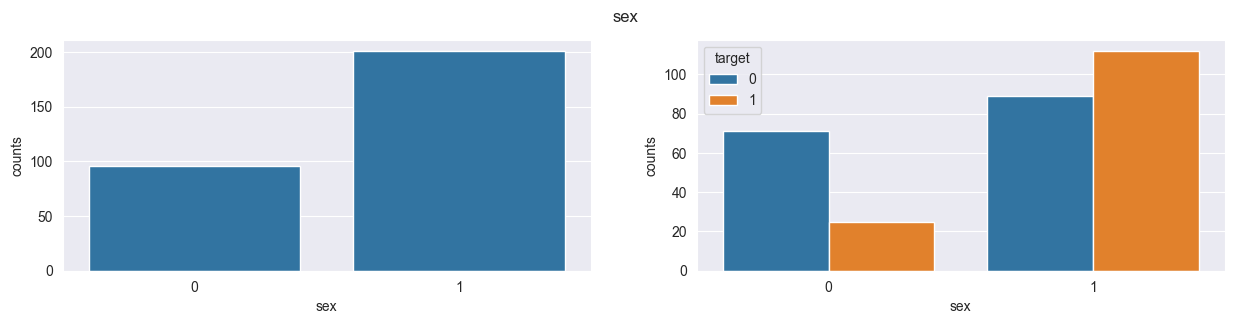

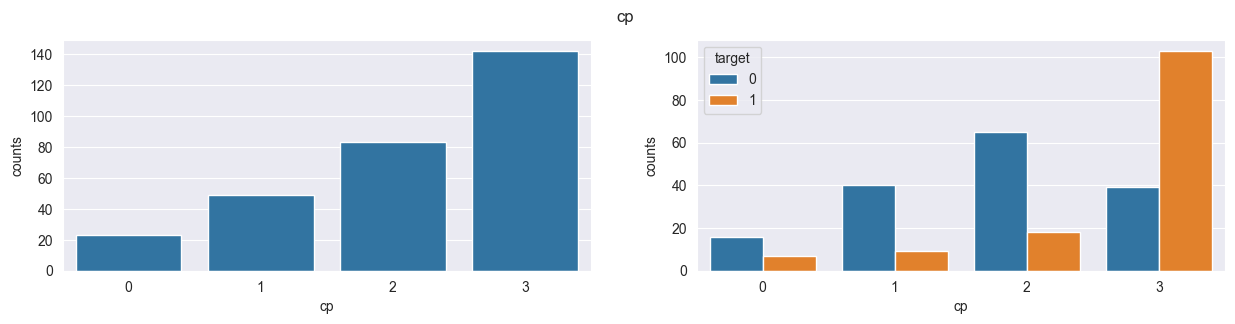

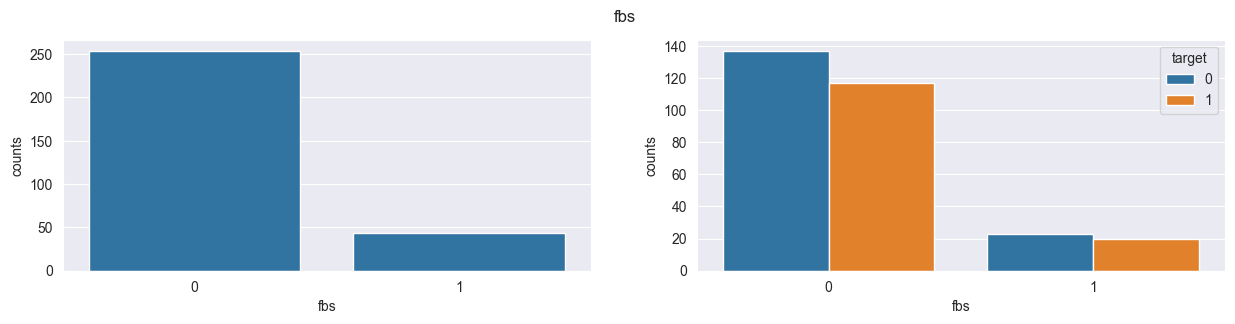

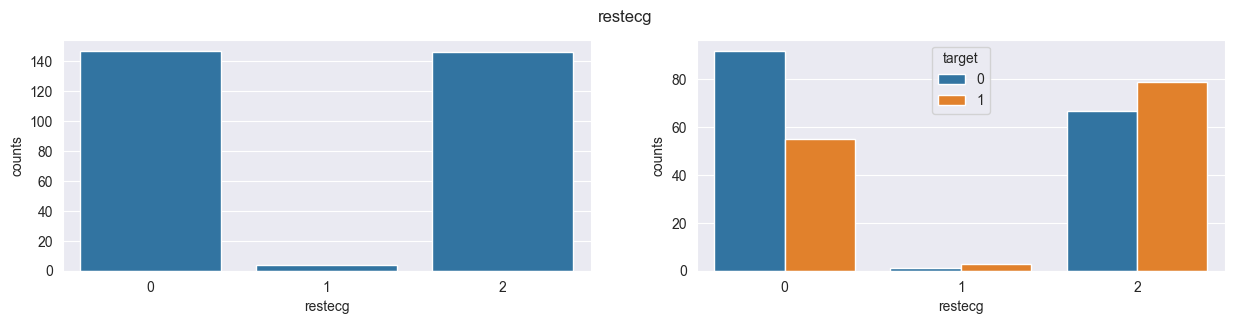

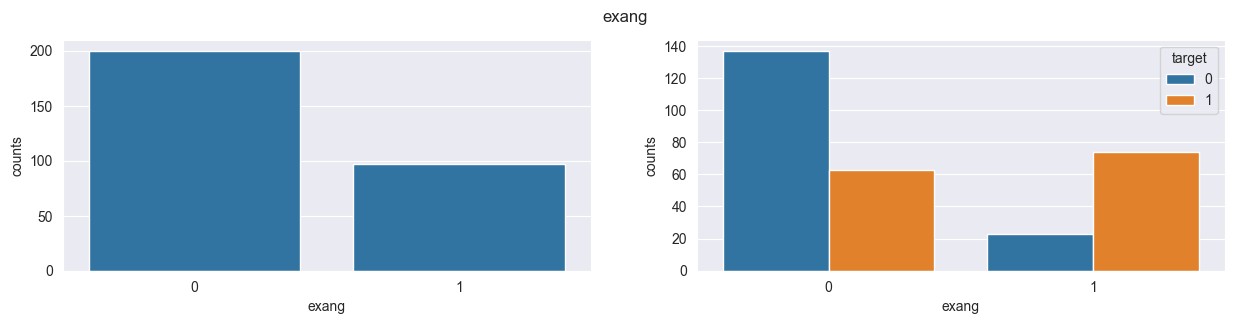

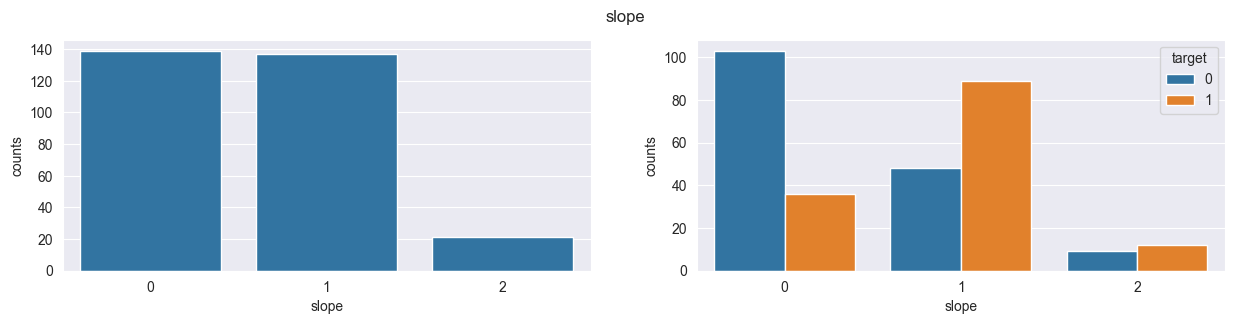

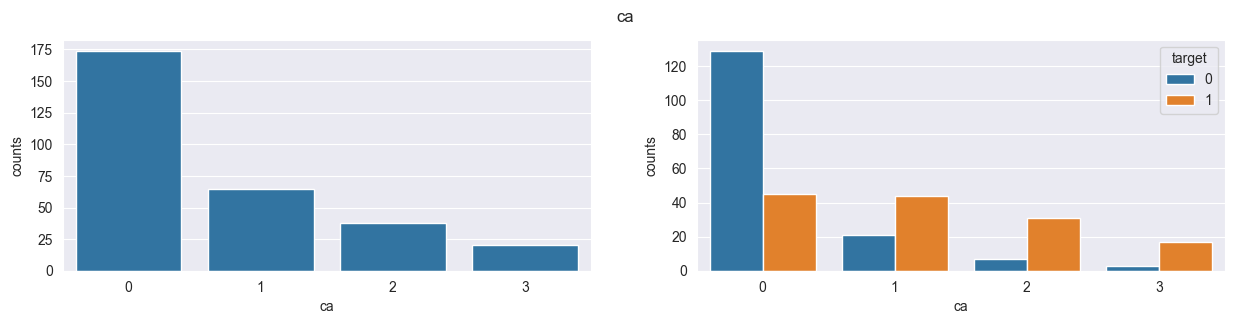

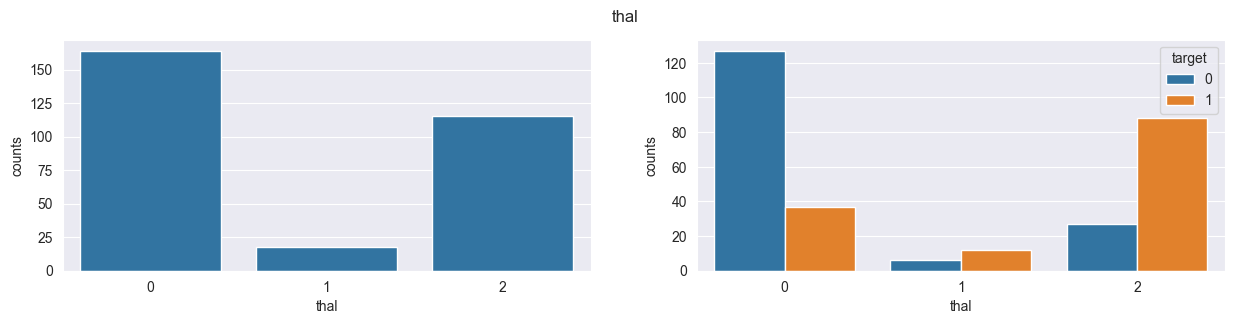

In [12]:
for feature in categorical_features:
    plot_categorical_feature(df, feature)

#### Матрица корреляций

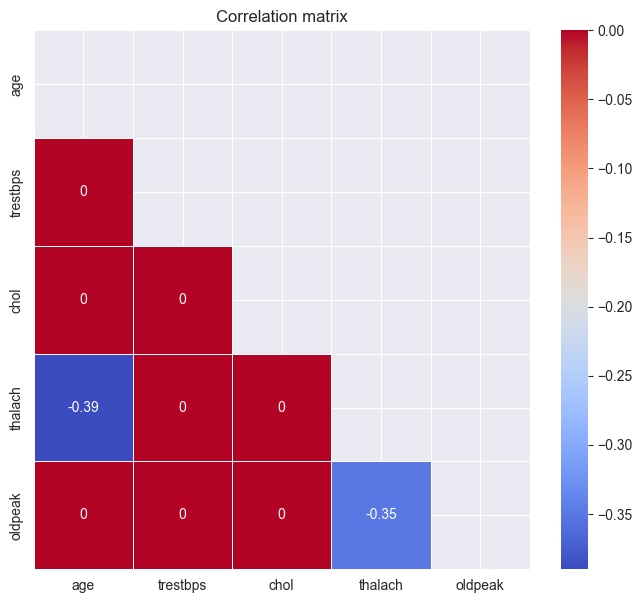

In [13]:
plt.figure(figsize=(8, 7))

corr_matrix = df[continuous_features + ["target"]].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5, cmap="coolwarm")

plt.title("Correlation matrix")
plt.show()

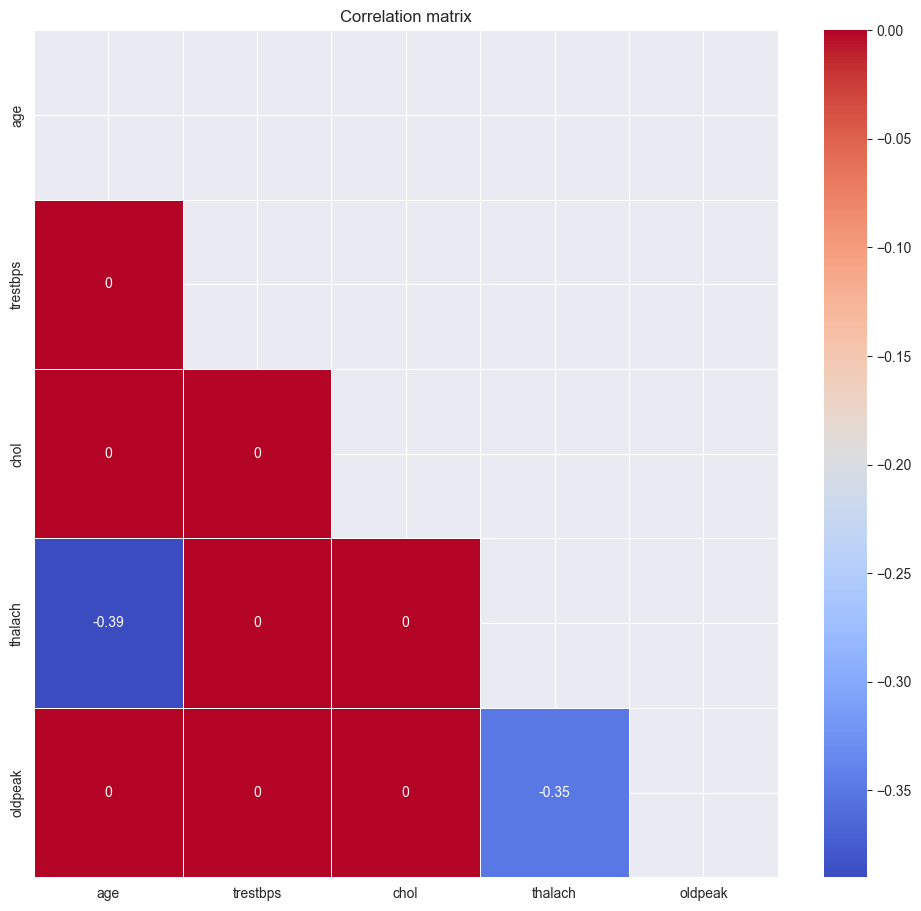

In [14]:
plt.figure(figsize=(12, 11))

corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5, cmap="coolwarm")

plt.title("Correlation matrix")
plt.show()

#### Pairplot в разрезе целевой переменной

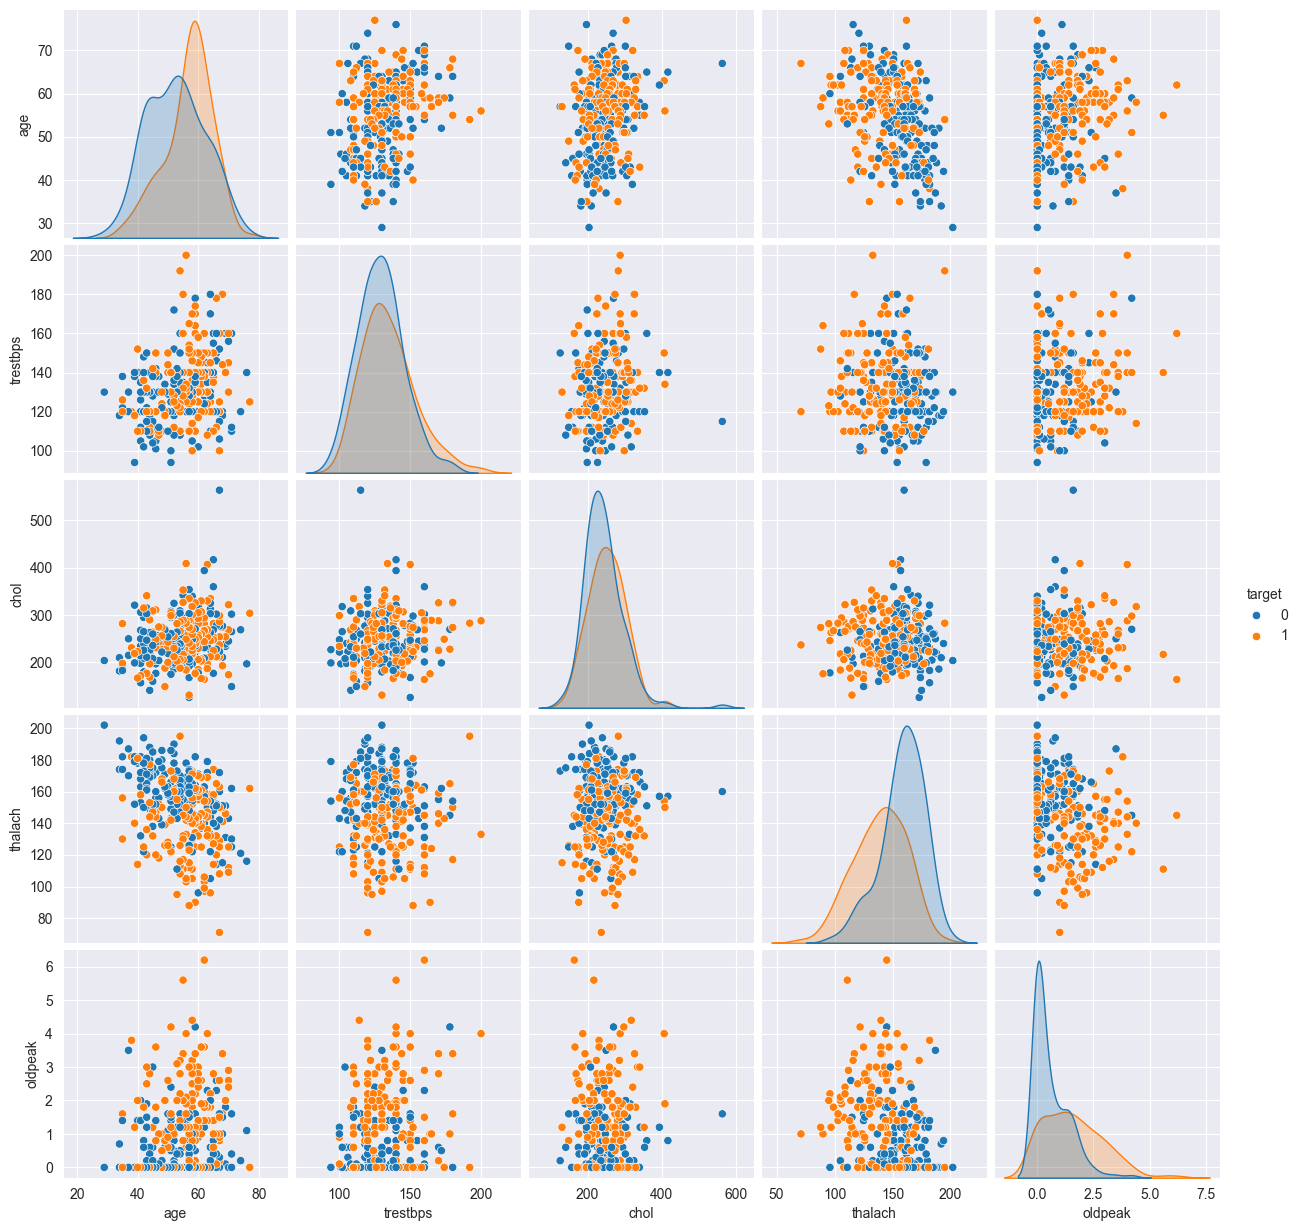

In [15]:
sns.pairplot(df[continuous_features + ["target"]], hue="target")
plt.show()

#### Общие выводы по EDA

1. Целевая переменная практически сбалансирована
2. Непрерывные признаки:
    - за исключением oldpeak распределены нормально
    - выбросов практически нет, поэтому не имеет смысла их удалять
    - нормализация на oldpeak невозможна из-за наличия нулей, поэтому попробуем дискретизацию признака, так как около нуля большая кучность для здоровых людей
3. Категориальные признаки:
    - Каких-то необычных явлений в распределениях нет. Единственное можно попробовать сделать из категориальных признаков dummy признаки 
4. Корреляции:
    - Сильно коррелирующих между собой признаков нет
    - На Pairplot нелинейных зависимостей тоже нет
    - Поэтому удалять какие-либо признаки не имеет смысла

### Baseline

In [16]:
model_pipeline(df, "baseline")
ALL_RESULTS

,name,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1
0,baseline,0.844363,0.846847,0.813725,0.846939,0.83,0.858929,0.866667,0.742857,0.962963,0.83871


### Эксперименты

#### Дискретизация признаков

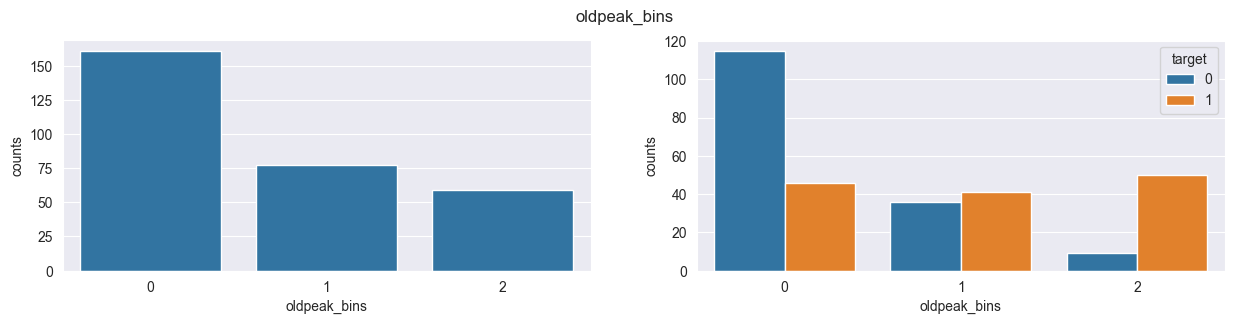

In [17]:
tmp_df = df.copy()

feature = "oldpeak"
tmp_df[f"{feature}_bins"] = pd.cut(
    tmp_df[feature],
    bins=[0, 1, 2, float("inf")],
    include_lowest=True,
    labels=[0, 1, 2],
    right=False,
)
tmp_df.drop(columns=["oldpeak"], inplace=True)
plot_categorical_feature(tmp_df, f"{feature}_bins")

In [18]:
model_pipeline(tmp_df, f"{feature}_bins")
ALL_RESULTS

,name,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1
0,baseline,0.844363,0.846847,0.813725,0.846939,0.830000,0.858929,0.866667,0.742857,0.962963,0.83871
0,oldpeak_bins,0.839461,0.842342,0.803922,0.845361,0.824121,0.858929,0.866667,0.742857,0.962963,0.83871


Метрики ухудшились

#### Dummy признаки

In [19]:
dummy_df = df.copy()

dummy_df = pd.concat(
    [
        pd.get_dummies(df[categorical_features]).astype("int"),
        dummy_df[continuous_features],
        dummy_df[["target"]],
    ],
    axis=1,
)

dummy_df

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,...,ca_3,thal_0,thal_1,thal_2,age,trestbps,chol,thalach,oldpeak,target
0,0,1,1,0,0,0,0,1,0,0,...,0,1,0,0,69,160,234,131,0.1,0
1,1,0,1,0,0,0,1,0,1,0,...,0,1,0,0,69,140,239,151,1.8,0
2,1,0,1,0,0,0,1,0,1,0,...,0,1,0,0,66,150,226,114,2.6,0
3,0,1,1,0,0,0,0,1,0,0,...,0,1,0,0,65,138,282,174,1.4,1
4,0,1,1,0,0,0,1,0,0,0,...,0,1,0,0,64,110,211,144,1.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0,1,0,0,0,1,1,0,1,0,...,0,0,0,1,40,152,223,181,0.0,1
293,0,1,0,0,0,1,1,0,1,0,...,0,0,0,1,39,118,219,140,1.2,1
294,0,1,0,0,0,1,1,0,1,0,...,0,0,0,1,35,120,198,130,1.6,1
295,1,0,0,0,0,1,1,0,1,0,...,0,1,0,0,35,138,183,182,1.4,0


In [20]:
model_pipeline(dummy_df, "dummy")
ALL_RESULTS

,name,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1
0,baseline,0.844363,0.846847,0.813725,0.846939,0.830000,0.858929,0.866667,0.742857,0.962963,0.838710
0,oldpeak_bins,0.839461,0.842342,0.803922,0.845361,0.824121,0.858929,0.866667,0.742857,0.962963,0.838710
0,dummy,0.855392,0.860360,0.794118,0.890110,0.839378,0.875000,0.880000,0.800000,0.933333,0.861538


Добились повышения метрик за исключением precision. Но нам это даже лучше, потому что мы предсказываем болезнь и нам важно не пропускать больных пациентов

### Поиск оптимального threshold

Будем стараться оптимально повысить recall, так как нам важно не пропускать больных пациентов

In [21]:
def plot_roc_curve(y_true, y_probs, pos_label, ax):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs, pos_label=pos_label)

    roc_auc = metrics.auc(fpr, tpr)
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot(ax=ax)
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve")


def plot_pr_curve(y_true, y_probs, pos_label, ax):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_true, y_probs, pos_label=pos_label
    )
    disp = metrics.PrecisionRecallDisplay(precision, recall)
    disp.plot(ax=ax)
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_title("PR curve")

In [22]:
df_train, df_test = train_test_split(
    dummy_df, test_size=0.25, stratify=dummy_df["target"], random_state=RANDOM_SEED
)

y_train_true = df_train.pop("target")
y_test_true = df_test.pop("target")

logreg = LogisticRegression(random_state=RANDOM_SEED)

scaler = StandardScaler().fit(df_train)
df_train_scale = scaler.transform(df_train)
df_test_scale = scaler.transform(df_test)

logreg.fit(df_train_scale, y_train_true)

y_train_probs = logreg.predict_proba(df_train_scale)[:, 1]
y_test_probs = logreg.predict_proba(df_test_scale)[:, 1]

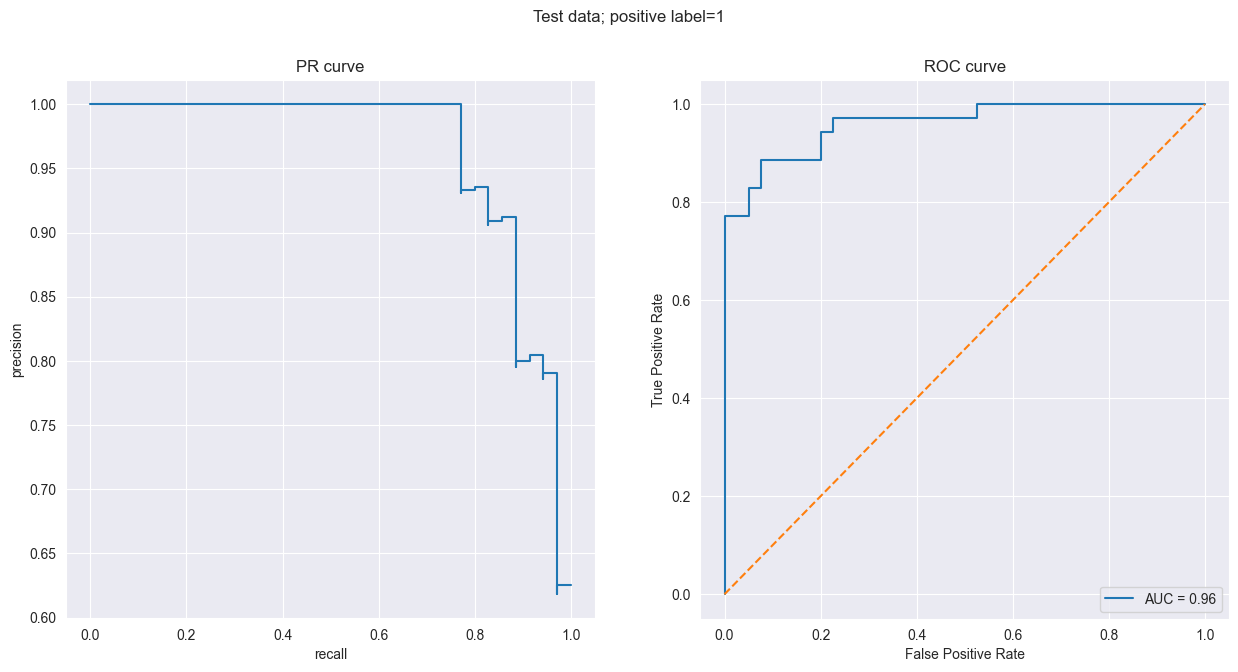

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plot_pr_curve(y_test_true, y_test_probs, pos_label=1, ax=axes[0])
plot_roc_curve(y_test_true, y_test_probs, pos_label=1, ax=axes[1])
fig.suptitle("Test data; positive label=1")
plt.show()

In [24]:
def get_train_test_metrics_by_threshold(
    y_train_true, y_train_probs, y_test_true, y_test_probs, threshold
):
    y_train_preds = np.array(y_train_probs >= threshold, dtype="int")
    y_test_preds = np.array(y_test_probs >= threshold, dtype="int")

    return get_train_test_metrics(
        y_train_true, y_train_preds, y_test_true, y_test_preds
    )

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_true, y_test_probs, pos_label=1)

metrics_by_thresholds = []
for threshold in thresholds:
    threshold_metrics = get_train_test_metrics_by_threshold(
        y_train_true, y_train_probs, y_test_true, y_test_probs, threshold
    )
    threshold_metrics.update({"threshold": threshold})
    metrics_by_thresholds.append(threshold_metrics)

In [26]:
pd.DataFrame(metrics_by_thresholds).sort_values("test_recall", ascending=False).head(10)

,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1,threshold
12,0.726961,0.707207,0.970588,0.614907,0.752852,0.737500,0.720000,1.000000,0.625000,0.769231,0.092086
13,0.520833,0.481982,1.000000,0.470046,0.639498,0.500000,0.466667,1.000000,0.466667,0.636364,0.010158
10,0.816422,0.806306,0.941176,0.721805,0.817021,0.873214,0.866667,0.971429,0.790698,0.871795,0.235037
11,0.751225,0.734234,0.960784,0.640523,0.768627,0.723214,0.706667,0.971429,0.618182,0.755556,0.115721
8,0.832353,0.824324,0.931373,0.748031,0.829694,0.871429,0.866667,0.942857,0.804878,0.868421,0.263305
9,0.816422,0.806306,0.941176,0.721805,0.817021,0.858929,0.853333,0.942857,0.785714,0.857143,0.235446
6,0.848775,0.846847,0.872549,0.809091,0.839623,0.905357,0.906667,0.885714,0.911765,0.898551,0.357016
7,0.844118,0.837838,0.921569,0.770492,0.839286,0.842857,0.840000,0.885714,0.794872,0.837838,0.313256
4,0.855392,0.860360,0.794118,0.890110,0.839378,0.889286,0.893333,0.828571,0.935484,0.878788,0.494286
5,0.861765,0.864865,0.823529,0.875000,0.848485,0.876786,0.880000,0.828571,0.906250,0.865672,0.462460


In [27]:
pd.DataFrame(metrics_by_thresholds).sort_values("test_f1", ascending=False).head(10)

,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1,threshold
6,0.848775,0.846847,0.872549,0.809091,0.839623,0.905357,0.906667,0.885714,0.911765,0.898551,0.357016
4,0.855392,0.860360,0.794118,0.890110,0.839378,0.889286,0.893333,0.828571,0.935484,0.878788,0.494286
10,0.816422,0.806306,0.941176,0.721805,0.817021,0.873214,0.866667,0.971429,0.790698,0.871795,0.235037
2,0.844118,0.851351,0.754902,0.905882,0.823529,0.885714,0.893333,0.771429,1.000000,0.870968,0.630307
8,0.832353,0.824324,0.931373,0.748031,0.829694,0.871429,0.866667,0.942857,0.804878,0.868421,0.263305
5,0.861765,0.864865,0.823529,0.875000,0.848485,0.876786,0.880000,0.828571,0.906250,0.865672,0.462460
9,0.816422,0.806306,0.941176,0.721805,0.817021,0.858929,0.853333,0.942857,0.785714,0.857143,0.235446
3,0.859559,0.864865,0.794118,0.900000,0.843750,0.860714,0.866667,0.771429,0.931034,0.843750,0.583241
7,0.844118,0.837838,0.921569,0.770492,0.839286,0.842857,0.840000,0.885714,0.794872,0.837838,0.313256
12,0.726961,0.707207,0.970588,0.614907,0.752852,0.737500,0.720000,1.000000,0.625000,0.769231,0.092086


In [28]:
ALL_RESULTS

,name,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1
0,baseline,0.844363,0.846847,0.813725,0.846939,0.830000,0.858929,0.866667,0.742857,0.962963,0.838710
0,oldpeak_bins,0.839461,0.842342,0.803922,0.845361,0.824121,0.858929,0.866667,0.742857,0.962963,0.838710
0,dummy,0.855392,0.860360,0.794118,0.890110,0.839378,0.875000,0.880000,0.800000,0.933333,0.861538


Выбирем строку 10 с threshold = 0.235037, таким образом мы сможем значительно повысить наш recall (precision естественно уменьшится), но при этом f1 тоже немного подрастет. Таким образом:
- test_recall: 0.800000 -> 0.971429
- test_precision: 0.933333 -> 0.790698
- test_f1: 0.861538 -> 0.871795

### Финальный класс обработки данных и модель

In [29]:
class DataPreprocessing:
    def __init__(self):
        self.scaler = StandardScaler()

        self.categorical_features = None
        self.continuous_features = None

    def _columns_recognition(self, df):
        self.categorical_features = list(df.select_dtypes("category").columns)
        self.continuous_features = list(df.select_dtypes(["int", "float"]).columns)
        self.categorical_features.remove("target")

    def _get_dummy_df(self, df):
        dummy_df = pd.concat(
            [
                pd.get_dummies(df[categorical_features]).astype("int"),
                df[continuous_features],
                df[["target"]],
            ],
            axis=1,
        )
        return dummy_df

    def _scaler_transform(self, df):
        feature_cols = list(df.columns)
        feature_cols.remove("target")
        scale_vals = self.scaler.transform(df.drop("target", axis=1))
        df[feature_cols] = scale_vals

        return df[feature_cols + ["target"]]

    def fit(self, data):
        self._columns_recognition(data)
        dummy_df = self._get_dummy_df(data)
        self.scaler.fit(dummy_df.drop("target", axis=1))

    def transform(self, data):
        dummy_df = self._get_dummy_df(data)
        scale_df = self._scaler_transform(dummy_df)
        return scale_df


def final_model_by_threshold(train, test, threshold):
    y_train_true = train.pop("target")
    y_test_true = test.pop("target")

    logreg = LogisticRegression(random_state=RANDOM_SEED)
    logreg.fit(train, y_train_true)

    y_train_probs = logreg.predict_proba(train)[:, 1]
    y_test_probs = logreg.predict_proba(test)[:, 1]

    y_train_pred = np.array(y_train_probs >= threshold, dtype="int")
    y_test_pred = np.array(y_test_probs >= threshold, dtype="int")

    results = get_train_test_metrics(
        y_train_true, y_train_pred, y_test_true, y_test_pred
    )
    add_results_to_compare("final", results)

    return y_train_pred, y_test_pred

In [30]:
df = pd.read_csv("heart_cleveland_upload.csv")
df.rename(columns={"condition": "target"}, inplace=True)

categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df[categorical_features + ["target"]] = df[categorical_features + ["target"]].astype(
    "category"
)

df_train, df_test = train_test_split(
    df, test_size=0.25, stratify=dummy_df["target"], random_state=RANDOM_SEED
)

In [31]:
THRESHOLD = 0.235
preproc = DataPreprocessing()
preproc.fit(df_train)
train_preproc = preproc.transform(df_train)
test_preproc = preproc.transform(df_test)

train_preds, test_preds = final_model_by_threshold(
    train_preproc, test_preproc, threshold=THRESHOLD
)
ALL_RESULTS

,name,train_auc,train_accuracy,train_recall,train_precision,train_f1,test_auc,test_accuracy,test_recall,test_precision,test_f1
0,baseline,0.844363,0.846847,0.813725,0.846939,0.830000,0.858929,0.866667,0.742857,0.962963,0.838710
0,oldpeak_bins,0.839461,0.842342,0.803922,0.845361,0.824121,0.858929,0.866667,0.742857,0.962963,0.838710
0,dummy,0.855392,0.860360,0.794118,0.890110,0.839378,0.875000,0.880000,0.800000,0.933333,0.861538
0,final,0.816422,0.806306,0.941176,0.721805,0.817021,0.873214,0.866667,0.971429,0.790698,0.871795


In [32]:
df_train['pred'] = train_preds
df_test['pred'] = test_preds

In [33]:
df_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,pred
69,35,1,1,122,192,0,0,174,0,0.0,0,0,0,0,0
134,47,1,2,130,253,0,0,179,0,0.0,0,0,0,0,0
122,51,0,2,130,256,0,2,149,0,0.5,0,0,0,0,0
108,54,1,2,120,258,0,2,147,0,0.4,1,0,2,0,1
176,64,0,3,130,303,0,0,122,0,2.0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,51,0,2,120,295,0,2,157,0,0.6,0,0,0,0,0
288,42,1,3,136,315,0,0,125,1,1.8,1,0,1,1,1
75,69,1,2,140,254,0,2,146,0,2.0,1,3,2,1,1
32,58,0,1,136,319,1,2,152,0,0.0,0,2,0,1,1


In [34]:
df_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,pred
179,63,1,3,130,254,0,2,147,0,1.4,1,1,2,1,1
224,57,1,3,150,276,0,2,112,1,0.6,1,1,1,1,1
103,57,1,2,128,229,0,2,150,0,0.4,1,1,2,1,1
24,71,0,1,160,302,0,0,162,0,0.4,0,2,0,0,1
247,54,1,3,110,206,0,2,108,1,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,41,1,1,120,157,0,0,182,0,0.0,0,0,0,0,0
97,59,1,2,150,212,1,0,157,0,1.6,0,0,0,0,0
29,62,1,1,128,208,1,2,140,0,0.0,0,0,0,0,0
19,42,1,0,148,244,0,2,178,0,0.8,0,2,0,0,1
